## Exploring Maritime Freight data – container volume and metric tonnage – in the U.S. 

Maritime shipping is important to the U.S. economy – vessels account for more than 50% of U.S. imports! This notebook will ingest, format, analyze, and graph some data about how much cargo comes into U.S. ports and how heavy it is.

You can get the data here: https://www.marad.dot.gov/resources/data-statistics/.

In [1]:
#Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Loading and arranging / formatting data

Our data is in 6 separate CSV files, so we'll need to load them in one-by-one, make a few transformations, and then join them into two sets of three. 

In [2]:
#Load data
totalTEU = pd.read_csv("totalTEU.csv")
importTEU = pd.read_csv("importTEU.csv")
exportTEU = pd.read_csv("exportTEU.csv")
totalMT = pd.read_csv("totalMT.csv")
importMT = pd.read_csv("importMT.csv")
exportMT = pd.read_csv("exportMT.csv")

The data is coming in a little jumbled, so we're going to have to do some work to get it ready for analysis. First – we're going to want to separate out the mapping from coasts to countries into its own dataframe, and remove the coasts column from each dataframe.

In [3]:
#Create a new dataframe of each city and its respective coast
coasts = totalTEU[['Coast','U.S. Custom Ports']]
#Set the index to the city
coasts.set_index('U.S. Custom Ports', inplace=True)

In [4]:
#Drop the coasts row from the dataframes
for df in [totalTEU, importTEU, exportTEU, totalMT, importMT, exportMT]:
    del df['Coast']

Next, to get things ready for grouping, we'll melt down our dataframes into a format where there are two separate columns for port and year.

In [5]:
#Melt down each dataframe into 3 columns: port, year, and respective value
totalTEU = totalTEU.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='totalTEU')
importTEU = importTEU.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='importTEU')
exportTEU = exportTEU.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='exportTEU')
totalMT = totalMT.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='totalMT')
importMT = importMT.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='importMT')
exportMT = exportMT.melt(id_vars='U.S. Custom Ports', var_name='year', value_name='exportMT')

Now we'll merge all of the above into on shipping dataframe.

In [6]:
#Merge together all TEU measures
TEUs = pd.merge(totalTEU,importTEU, on=['U.S. Custom Ports', 'year']).merge(exportTEU, on=['U.S. Custom Ports', 'year'])
#Merge together all MT measures
MTs = pd.merge(totalMT,importMT, on=['U.S. Custom Ports', 'year']).merge(exportMT, on=['U.S. Custom Ports', 'year'])
#Merge together everything
shipping = pd.merge(TEUs, MTs, on=['U.S. Custom Ports', 'year'])

Finally, we'll convert the numbers in our dataframe into floats.

In [7]:
#Since some of the numbers are floats/ints and some are strings, we'll need to create a function to clean them
def cleanNum(x):
    if type(x) != str:
        return x
    elif type(x) == str:
        return float(x.replace(',',''))

In [8]:
#Apply our cleanNum function to 
for col in shipping.loc[:,'totalTEU':]:
    shipping[col] = shipping[col].apply(cleanNum)

In [9]:
shipping.tail()

,U.S. Custom Ports,year,totalTEU,importTEU,exportTEU,totalMT,importMT,exportMT
987,"Tampa, FL",2015,38406.0,28055.0,10352.0,337579.0,221477.0,116102.0
988,"Vancouver, WA",2015,2752.0,1836.0,916.0,27401.0,13939.0,13462.0
989,"West Palm Beach, FL",2015,164028.0,29863.0,134164.0,1372871.0,357895.0,1014976.0
990,"Wilmington, DE",2015,194529.0,164912.0,29618.0,1821914.0,1621830.0,200084.0
991,"Wilmington, NC",2015,232118.0,124698.0,107420.0,2002633.0,896591.0,1106042.0


In [15]:
#Write out to CSV to use for any other applications / SQL
#First, remove the comma and everything after it for MySQL use (it screws up the import)
shippingSQL = shipping.copy()
shippingSQL['U.S. Custom Ports'] = shippingSQL['U.S. Custom Ports'].apply(lambda x: x.split(',')[0])
shippingSQL.to_csv("shippingSQL.csv", index=False)

### Basic overview

To get a better idea of what we're looking at, let's look at some summary statistic and basic data plots.

In [11]:
#To make indexing slightly easier
shipping = shipping.rename(columns = {'U.S. Custom Ports': 'port'})

In [12]:
pd.options.display.float_format = '{:.1f}'.format
shipping.describe()

,totalTEU,importTEU,exportTEU,totalMT,importMT,exportMT
count,991.0,992.0,992.0,992.0,992.0,992.0
mean,425954.6,261785.3,159417.9,3413283.6,1884284.4,1528999.2
std,1001895.5,693505.5,326867.2,7589919.9,4579770.2,3177258.9
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,238.5,72.0,56.5,2429.2,666.0,582.0
50%,23842.0,13147.5,8565.5,208243.0,104056.0,72146.0
75%,210903.0,121558.5,103519.8,1987326.5,1208895.8,943993.8
max,6019633.0,4426542.0,1953607.0,44803371.0,26999878.0,20167385.0


Some initial notes we can get from the above:

1) The average U.S. port imports 1.65x TEUs as it exports, but only 1.23x the Metric Tonnage.

In [13]:
print("Average import TEUs: " + str(shipping['importTEU'].mean()))
print("Average export TEUs: " + str(shipping['exportTEU'].mean()))
print("Import to export TEU ratio: " + str(shipping['importTEU'].mean()/ shipping['exportTEU'].mean()))
print("\n")
print("Average import MTs: " + str(shipping['importMT'].mean()))
print("Average export MTs: " + str(shipping['exportMT'].mean()))
print("Import to export MT ratio: " + str(shipping['importMT'].mean()/ shipping['exportMT'].mean()))

Average import TEUs: 261785.251008
Average export TEUs: 159417.943548
Import to export TEU ratio: 1.64213165207


Average import MTs: 1884284.4123
Average export MTs: 1528999.17238
Import to export MT ratio: 1.23236457307


2) Given that the mean and median are so far off each other, our distribution might be skewed. 

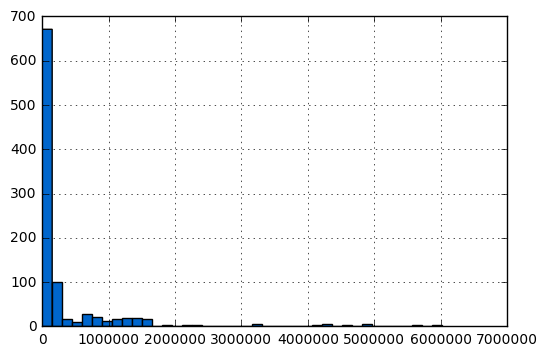

In [14]:
shipping['totalTEU'].hist(bins=40, color='#0066cc')

The histogram shows a significant skew with a long right tail. To clean this up a little bit, we can also take the average TEUs shipped for each port and plot a histogram of that.

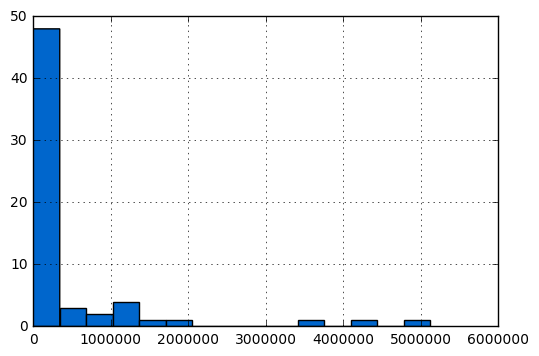

In [15]:
shipping.groupby('port').mean()['totalTEU'].hist(bins=15, color='#0066cc')

It also doesn't seem like there are any ports in the dataset that have never shipped a TEU. So there are some ports that are shipping *very few* items, but not none.

In [465]:
sum(shipping.groupby('port').sum()['totalTEU'] == 0)

0

In summary, we can safely say that within our dataset there's a long tail for U.S. ports – a small amount of the ports in the dataset ship the overwhelming majority of TEUs.

### Which ports import and export the most?

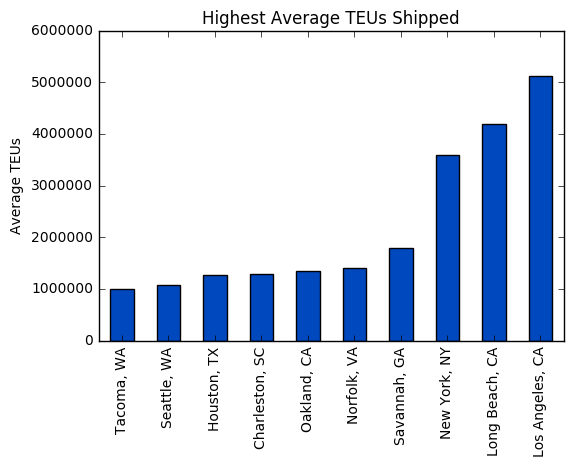

In [62]:
#Highest average shipping volume
topVolume = shipping.groupby('port').mean()['totalTEU'].sort_values().tail(10)
topVolume.plot(kind='bar', color='#0048be')
plt.title('Highest Average TEUs Shipped')
plt.xlabel('')
plt.ylabel('Average TEUs')

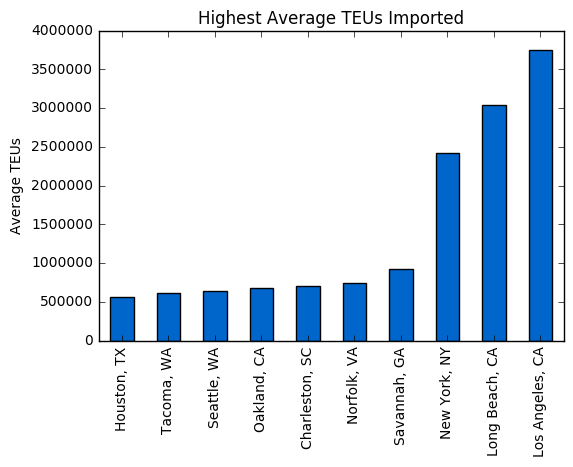

In [61]:
#Highest average import volume
topImportVolume = shipping.groupby('port').mean()['importTEU'].sort_values().tail(10)
topImportVolume.plot(kind='bar', color='#0066cc')
plt.title('Highest Average TEUs Imported')
plt.xlabel('')
plt.ylabel('Average TEUs')

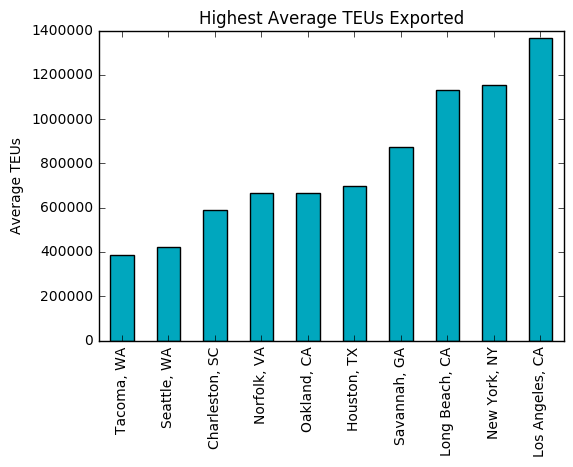

In [58]:
#Highest average export volume
topExportVolume = shipping.groupby('port').agg({'exportTEU': np.mean}).sort_values('exportTEU').tail(10)
topExportVolume.plot(kind='bar', color='#00a7be', legend='')
plt.title('Highest Average TEUs Exported')
plt.xlabel('')
plt.ylabel('Average TEUs')

LA, NYC, Long Beach, and Savannah occupy the top 4 spots on all 3 of these lists. The fifth spot goes to Norfolk for total TEUs and imported TEUs, but Houston has the slot for exports. Let's graph all of them together for perspective.

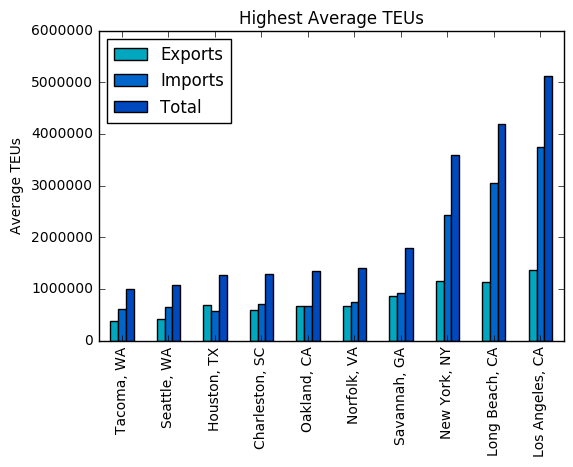

In [42]:
#Highest average export, import, and total TEUs shipped in one graph
topTEUVolumes = shipping.groupby('port').mean()[['exportTEU', 'importTEU', 'totalTEU']].sort_values('totalTEU').tail(10)
topTEUVolumes.plot(kind='bar', color=['#00a7be', '#0066cc', '#0048be'])
plt.legend(labels=['Exports', 'Imports', 'Total'], loc='upper left')
plt.title('Highest Average TEUs')
plt.xlabel('')
plt.ylabel('Average TEUs')

### Which ports have the least balanced import / export ratio?

Like we saw above in the descriptive statistics, the average U.S. port imports 1.6x as much as it exports. 

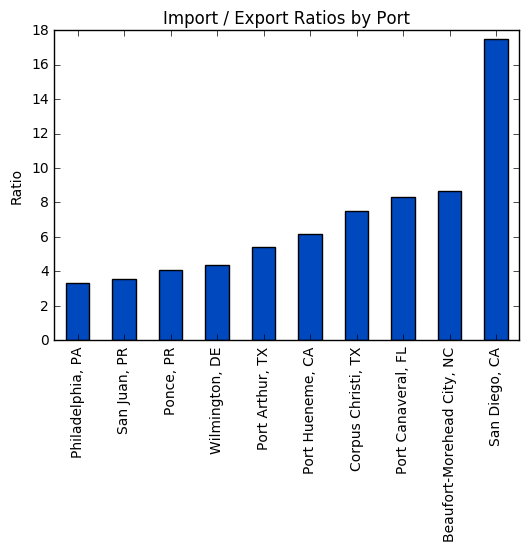

In [73]:
importExport = (shipping.groupby('port').mean()['importTEU'] / shipping.groupby('port').mean()['exportTEU']).sort_values()
importExport.tail(10).plot(kind='bar', legend='', color='#0048be')
plt.title('Import / Export Ratios by Port')
plt.xlabel('')
plt.ylabel('Ratio')

We can take the other side of the series to find the ports with the highest export / import ratio.

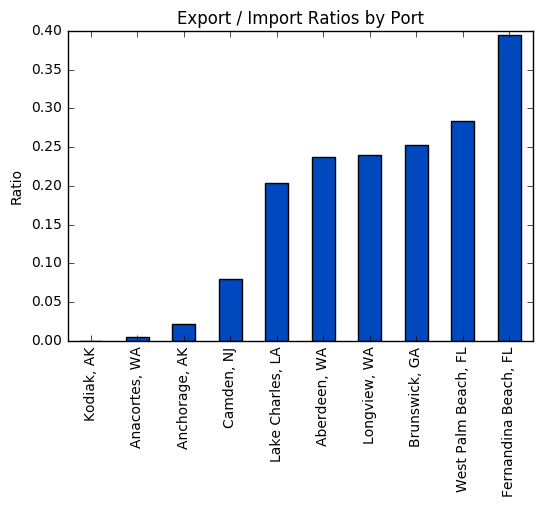

In [74]:
importExport.head(10).plot(kind='bar', legend='', color='#0048be')
plt.title('Export / Import Ratios by Port')
plt.xlabel('')
plt.ylabel('Ratio')

Kodiak takes the top spot, since it has no imports at all, followed by Anacortes. Looks like two out of the bottom 3 here are in Alaska. I guess they don't import much there!

### Which ports import the heaviest and lightest freight?

The ratio of Metric Tons to TEUs shipped should indicate how heavy freight typically is at a given port.

In [76]:
weight = shipping.groupby('port').mean()['totalMT'] / shipping.groupby('port').mean()['totalTEU']

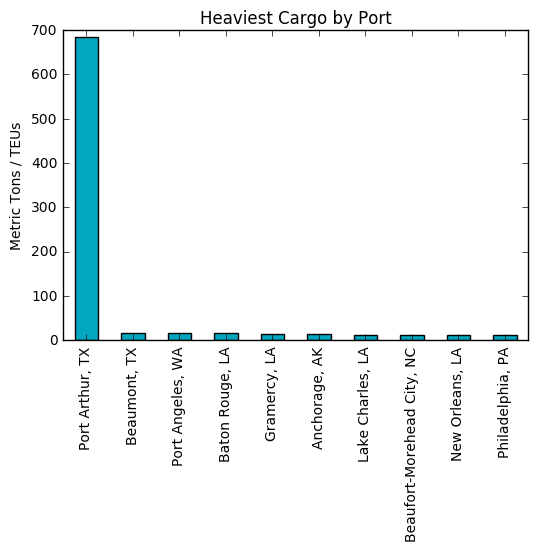

In [90]:
weight.sort_values(ascending=False).head(10).plot(kind='bar', color='#00a7be')
plt.title('Heaviest Cargo by Port')
plt.xlabel('')
plt.ylabel('Metric Tons / TEUs')

Port Arthur is so outsized that it's making the rest of the graph tough to read. Let's remove it and see what it looks like.

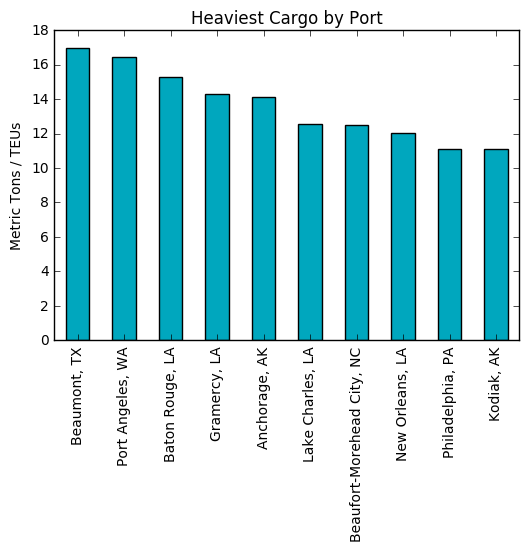

In [91]:
weight[weight.index != 'Port Arthur, TX'].sort_values(ascending=False).head(10).plot(kind='bar', color='#00a7be')
plt.title('Heaviest Cargo by Port')
plt.xlabel('')
plt.ylabel('Metric Tons / TEUs')

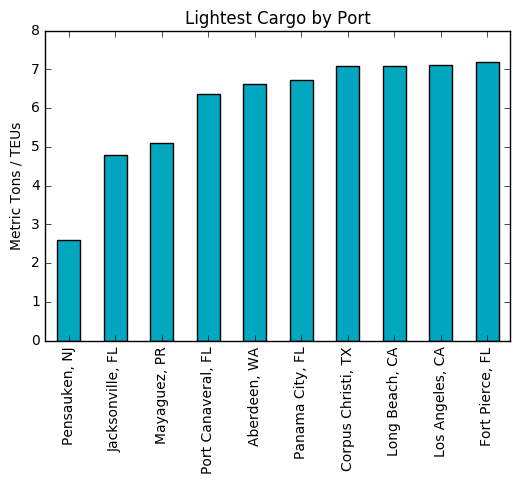

In [93]:
weight.sort_values().head(10).plot(kind='bar', color='#00a7be')
plt.title('Lightest Cargo by Port')
plt.xlabel('')
plt.ylabel('Metric Tons / TEUs')

Pensauken, NJ takes the spot for lightest average cargo, although 4 out of the top 10 lightest ports are in Florida.

### Mapping the relative size of ports

In [137]:
from mpl_toolkits.basemap import Basemap as Basemap
from geopy.geocoders import Nominatim
import math

In [138]:
#Separate ports and totalTEU into a dataframe for plotting
ports = shipping.groupby('port').mean()['totalTEU']

In [139]:
#Remove the state from each city and insert into new list
portCities = []
for port in ports.index:
    portCity = port.split(',')[0]
    portCities.append(portCity)

In [140]:
#Create a new tuple with the index as cities
portsMap = zip(portCities, ports)
#Sort tuples by totalTEU value
portsMap.sort(key=lambda x: x[1])

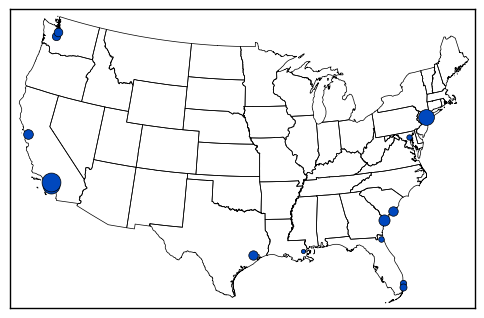

In [141]:
#Get the location of each city and plot it
scale = .006
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)
# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

geolocator = Nominatim()
#Use only the top 15 ports by totalTEU
for (port,TEU) in portsMap[47:62]:
    try:
        loc = geolocator.geocode(port)
        x, y = map(loc.longitude, loc.latitude)
        map.plot(x,y,marker='o',color='#0048be',markersize=int(math.sqrt(TEU))*scale)
    except AttributeError:
        pass
plt.show()